# Data Exploration
<p>
    This notebook should contain preliminary data exploration and graphing of the data set.
</p>
<p>
    Last modified 4/14/18 by Kate Baumli
</p>

In [2]:
! pip install gender-guesser
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katebaumli/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

First load up the data.

In [3]:
filepath = '../data/kaggle-data/'
filename = 'merged_data.csv'
data = pd.read_csv(filepath + filename)
# drop extra index column
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# Output suppressed
#data.describe()
#data.info()
data.head()

,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url.1,views
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morning\nhow are you\nlaughter\nits been ...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chris\nand its truly a grea...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,if youre here today — and im very happy that y...,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [5]:
# Output suppressed, this is to check data was cleaned properly
#print(data.clean_transcripts[0]) 

In [6]:
print('The number of NaN clean transcripts is:\t\t{}'.
      format(data.clean_transcripts.isnull().sum()))
print('The number of NaN original transcripts is:\t{}'.
      format(data.transcript.isnull().sum()))

The number of NaN clean transcripts is:		83
The number of NaN original transcripts is:	83


That is something we need to look into... For the moment I am going to drop them.

In [7]:
# Assuming the NaN are the same rows in both columns
data_trimmed = data.dropna(subset=['clean_transcripts'])

In [8]:
# Find transcript with the most words
maxLen = 0
for row in data_trimmed.itertuples():
    if len(row.clean_transcripts.split()) >= maxLen:
        maxLen = len(row.clean_transcripts.split()) 
        longestTalk = row.name
print(maxLen)
print(longestTalk)

9176
Zeynep Tufekci: Machine intelligence makes human morals more important


In [10]:
def mostFrequentWords(df,num_words_desired,descriptor=''):
    # This loops over all rows in the clean transcripts column and 
    # puts every word in every transcript into a list called words
    words = []
    for row in df.itertuples():
        words.extend(row.clean_transcripts.split())
    print(descriptor,'Number of words:',len(words))

    # Get counts for each word
    word_counts = Counter(words)
    print(descriptor,'Number of unique words:',len(word_counts))

    # Grab the most common words
    most_common = dict()
    for word, word_count in word_counts.most_common(num_words_desired):
        most_common[word] = word_count
    print('The',num_words_desired, 'most common words in all',descriptor,'TED talk transcripts:\n',list(most_common.keys()))

    # Plot a histogram
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(most_common.keys()), list(most_common.values()))
    title = 'The '+str(num_words_desired)+' Most Common Words In All '+ descriptor+' TED Talk Transcripts'
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    
    # Return list of most common words
    return most_common

 Number of words: 5097705
 Number of unique words: 103043
The 75 most common words in all  TED talk transcripts:
 ['the', 'and', 'to', 'of', 'a', 'that', 'in', 'i', 'you', 'is', 'we', 'it', 'this', 'so', 'was', 'for', 'are', 'have', 'but', 'they', 'on', 'with', 'its', 'what', '—', 'about', 'can', 'be', 'as', 'at', 'not', 'my', 'all', 'do', 'were', 'if', 'one', 'from', 'people', 'our', 'like', 'or', 'an', 'just', 'these', 'when', 'there', 'because', 'by', 'he', 'how', 'very', 'going', 'more', 'out', 'had', 'their', 'your', 'me', 'thats', 'up', 'them', 'would', 'who', 'think', 'which', 'get', 'really', 'see', 'im', 'now', 'some', 'laughter', 'us', 'has']


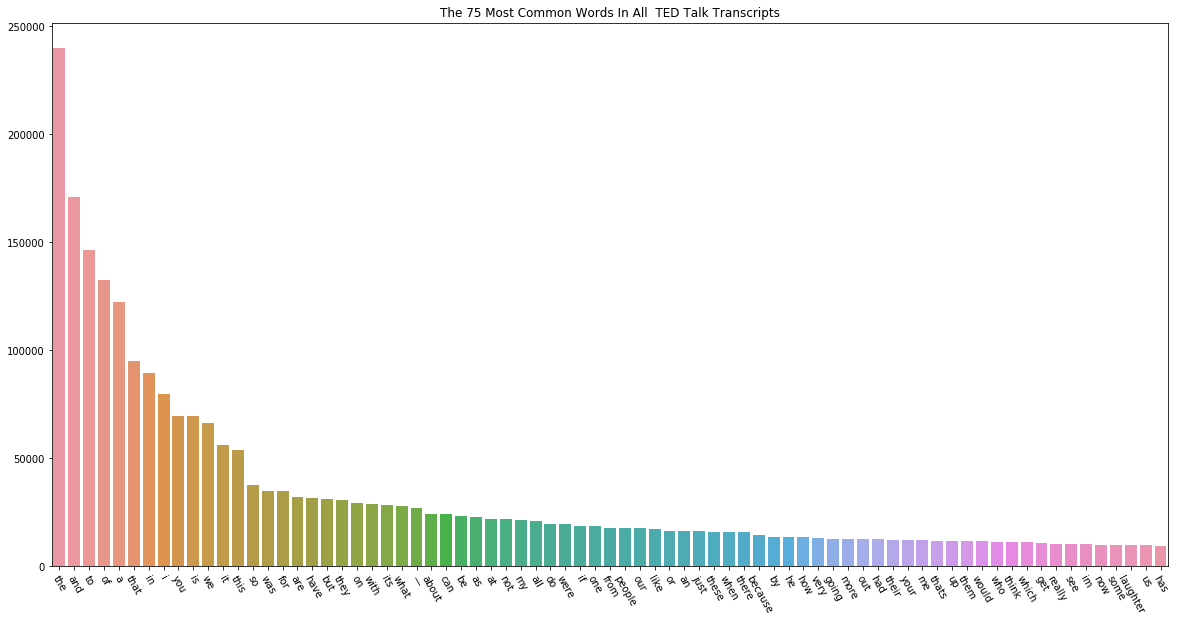

In [11]:
_ = mostFrequentWords(data_trimmed,75)

In [12]:
def mostFrequentWordsCopy(df,num_words_desired,descriptor=''):
    # This loops over all rows in the clean transcripts column and 
    # puts every word in every transcript into a list called words
    words = []
    for row in df.itertuples():
        words.extend(row.clean_transcripts.split())
    print(descriptor,'Number of words:',len(words))
    
    ## Removing Stopwords
    filtered_words =[]
    for token in words: 
        if token not in stopwords.words('english'):
            filtered_words.append(token)
    print("Done removing Stop words")
    words = filtered_words
    # Get counts for each word
    word_counts = Counter(words)
    print(descriptor,'Number of unique words:',len(word_counts))

    # Grab the most common words
    most_common = dict()
    for word, word_count in word_counts.most_common(num_words_desired):
        most_common[word] = word_count
    print('The',num_words_desired, 'most common words in all',descriptor,'TED talk transcripts:\n',list(most_common.keys()))

    # Plot a histogram
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(most_common.keys()), list(most_common.values()))
    title = 'The '+str(num_words_desired)+' Most Common Words In All '+ descriptor+' TED Talk Transcripts'
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    
    # Return list of most common words
    return most_common

In [16]:
_ = mostFrequentWordsCopy(data_trimmed,75)

 Number of words: 5097705


KeyboardInterrupt: 

### Let's break the data set into two segments based on (guessed) speaker gender

In [17]:
genDetector = gender.Detector()
speakerNames = data_trimmed.main_speaker.tolist()

speakerFirstNames = []
genders = []
for name in speakerNames:
    firstLastName = name.split(' ')
    firstName = firstLastName[0]
    speakerFirstNames.append(firstName)
    genders.append(genDetector.get_gender(firstName))
data_trimmed['gender'] = genders


/Users/katebaumli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


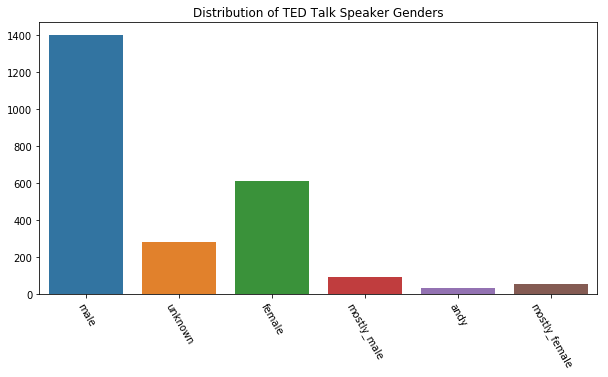

In [18]:
# Plot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

I'm going to go ahead and add the "mostly_female" names to female category and "mostly_male" names to male category. Unsure what to do about androgynous/unknown categories. We might have to go through and manually label these.<p>
Also, since classes are skewed we should normalize features when comparing.

In [19]:
for i,gender in enumerate(genders):
    if gender == 'mostly_male':
        genders[i] = 'male'
    if gender == 'mostly_female':
        genders[i] = 'female'
    if gender == 'andy':
        genders[i] = 'unknown' # No need to have 2 unknown categories if we're going to have to manually label anyways

/Users/katebaumli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


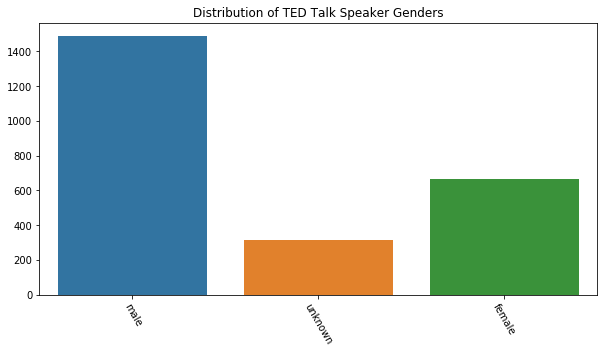

In [20]:
data_trimmed['gender'] = genders
# Replot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Right off the bat we can see that about twice as many speakers are men than women(disregarding the unknown). Let's compare the average # of views of men vs women.

In [21]:
menTED = data_trimmed[data_trimmed['gender'] == 'male']
womenTED = data_trimmed[data_trimmed['gender'] == 'female']
print('Description of male speaker TED data:')
menTED.describe()
print('Description of female speaker TED data:')
womenTED.describe()

Description of male speaker TED data:


,comments,duration,film_date,languages,num_speaker,published_date,views
count,1490.000000,1490.000000,1.490000e+03,1490.000000,1490.000000,1.490000e+03,1.490000e+03
mean,205.567114,860.734228,1.300597e+09,27.838926,1.024161,1.326112e+09,1.723878e+06
std,306.483377,402.323638,1.232214e+08,9.079876,0.166201,8.987412e+07,2.496100e+06
min,9.000000,135.000000,7.464960e+07,0.000000,1.000000,1.151367e+09,6.666800e+04
25%,70.000000,600.250000,1.248134e+09,23.000000,1.000000,1.254403e+09,7.441788e+05
50%,128.000000,894.000000,1.316822e+09,28.000000,1.000000,1.327637e+09,1.140840e+06
75%,238.000000,1074.000000,1.383091e+09,33.000000,1.000000,1.397121e+09,1.777379e+06
max,6404.000000,5256.000000,1.493078e+09,72.000000,3.000000,1.496418e+09,4.722711e+07


Description of female speaker TED data:


,comments,duration,film_date,languages,num_speaker,published_date,views
count,666.000000,666.000000,6.660000e+02,666.000000,666.000000,6.660000e+02,6.660000e+02
mean,188.833333,792.277778,1.342679e+09,28.342342,1.031532,1.358917e+09,1.745882e+06
std,251.704674,315.409746,1.047912e+08,8.277694,0.252321,9.052727e+07,2.689112e+06
min,6.000000,140.000000,8.863776e+08,0.000000,1.000000,1.152490e+09,1.211860e+05
25%,64.000000,577.250000,1.280167e+09,24.000000,1.000000,1.291940e+09,8.127375e+05
50%,120.000000,794.000000,1.354795e+09,28.000000,1.000000,1.362329e+09,1.131452e+06
75%,207.750000,1010.250000,1.432274e+09,33.000000,1.000000,1.441098e+09,1.616600e+06
max,2877.000000,2853.000000,1.492992e+09,57.000000,4.000000,1.496401e+09,4.315540e+07


Let's compare the frequency of words:

Male Speaker Number of words: 3124571
Male Speaker Number of unique words: 80746
The 75 most common words in all Male Speaker TED talk transcripts:
 ['the', 'and', 'to', 'of', 'a', 'that', 'in', 'i', 'you', 'is', 'we', 'it', 'this', 'so', 'was', 'for', 'are', 'have', 'they', 'but', 'on', 'its', 'with', 'what', '—', 'about', 'can', 'be', 'as', 'at', 'not', 'my', 'all', 'do', 'were', 'if', 'one', 'from', 'like', 'people', 'our', 'or', 'an', 'just', 'these', 'there', 'when', 'because', 'by', 'he', 'how', 'very', 'going', 'out', 'more', 'had', 'your', 'me', 'thats', 'up', 'their', 'them', 'would', 'which', 'think', 'who', 'get', 'see', 'really', 'im', 'now', 'some', 'laughter', 'then', 'dont']


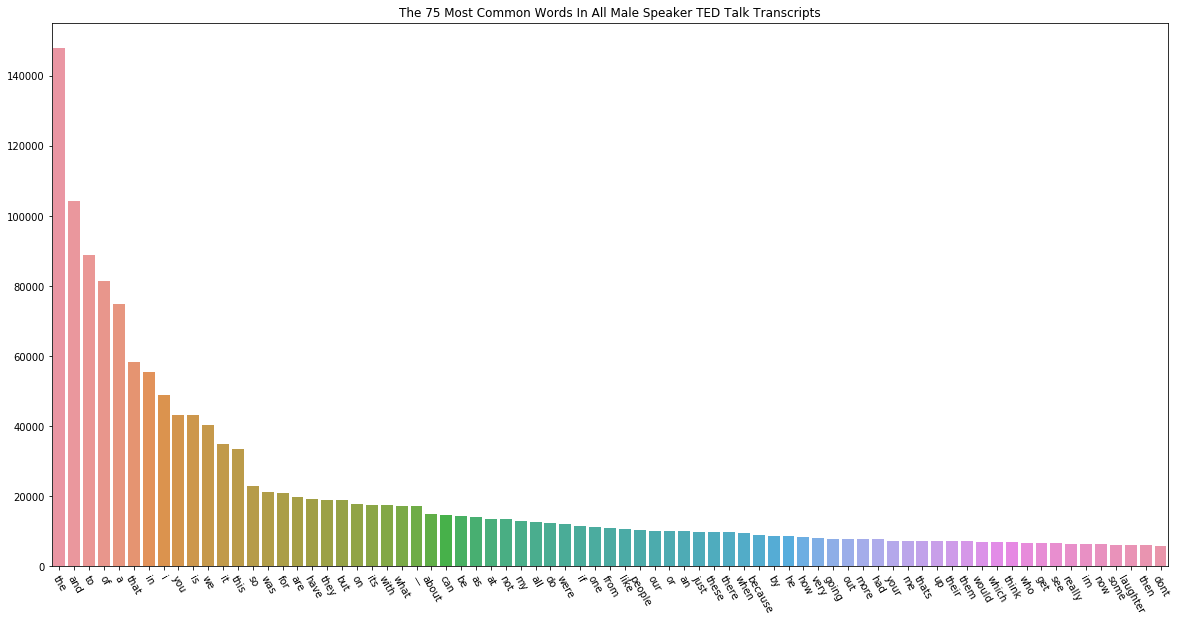

Female Speaker Number of words: 1341973
Female Speaker Number of unique words: 50886
The 75 most common words in all Female Speaker TED talk transcripts:
 ['the', 'and', 'to', 'of', 'a', 'that', 'in', 'i', 'is', 'we', 'you', 'it', 'this', 'so', 'was', 'for', 'but', 'are', 'they', 'have', 'on', 'with', 'its', 'what', '—', 'can', 'about', 'be', 'my', 'as', 'not', 'at', 'all', 'our', 'do', 'were', 'one', 'people', 'from', 'if', 'like', 'when', 'an', 'just', 'these', 'or', 'there', 'because', 'how', 'he', 'had', 'by', 'their', 'very', 'more', 'out', 'your', 'would', 'me', 'going', 'who', 'them', 'up', 'thats', 'get', 'which', 'really', 'think', 'see', 'us', 'now', 'im', 'has', 'some', 'will']


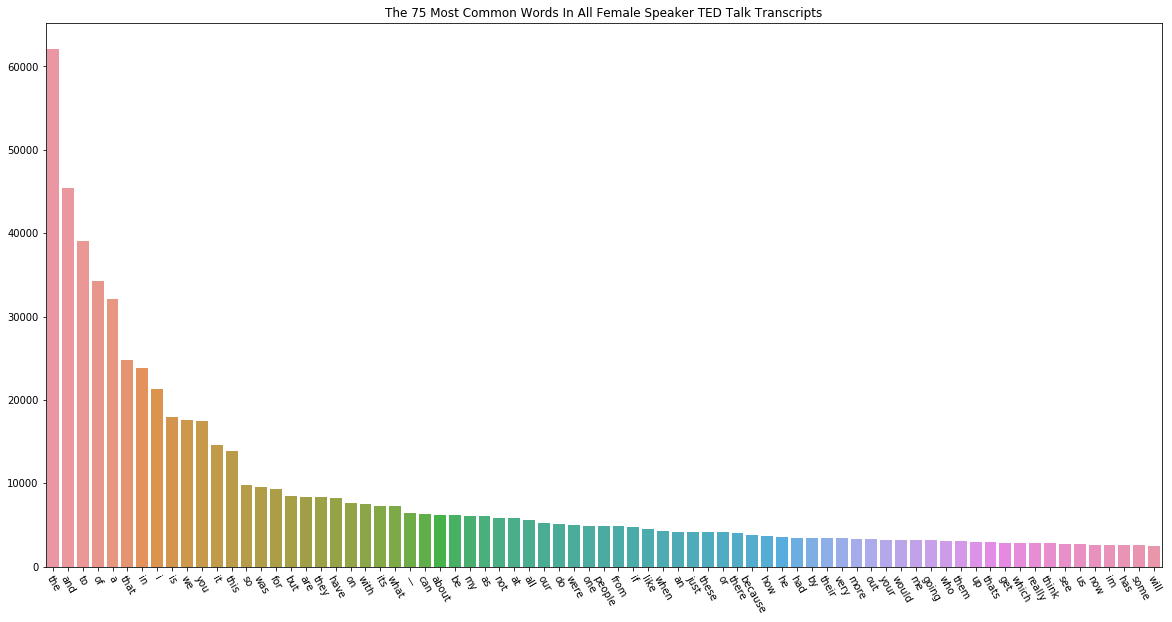

In [22]:
maleCommonWords = mostFrequentWords(menTED,75,'Male Speaker')
femaleCommonWords = mostFrequentWords(womenTED,75,'Female Speaker')

In [23]:
onlyMaleCommonWords = [word for word in maleCommonWords.keys() if word not in femaleCommonWords]
print(onlyMaleCommonWords) 
onlyFemaleCommonWords = [word for word in femaleCommonWords.keys() if word not in maleCommonWords]
print(onlyFemaleCommonWords)

['laughter', 'then', 'dont']
['us', 'has', 'will']


### Previous research on the differences of speech patterns between men and women, we have found that women are more likely to use speech qualifiers/intensifiers such as 'very','so','such','extremely','really','totally','absolutely', or 'too'. Let's look into that a little more here and compare our talks:

In [24]:
def menVsWomenWordCounts(wordsToCount):    
    maleWords = []
    for row in menTED.itertuples():
        maleWords.extend(row.clean_transcripts.split())
    
    femaleWords = []
    for row in womenTED.itertuples():
        femaleWords.extend(row.clean_transcripts.split())
    
    # Get counts for each word
    maleWordCounts = Counter(maleWords)
    femaleWordCounts = Counter(femaleWords)

    # Normalize counts by number of total words spoken by men 
    normalizedMaleWordCounts = {}
    for word,count in dict(maleWordCounts).items():
        normalizedMaleWordCounts[word] = count/float(len(maleWords))

    # Normalize counts by number of total words spoken by women 
    normalizedFemaleWordCounts = {}
    for word,count in dict(femaleWordCounts).items():
        normalizedFemaleWordCounts[word] = count/float(len(femaleWords))

    maleCount = 0
    for word,count in normalizedMaleWordCounts.items():
        if word in wordsToCount:
            maleCount += count
        
    femaleCount = 0
    for word,count in normalizedFemaleWordCounts.items():
        if word in wordsToCount:
            femaleCount += count
    return maleCount, femaleCount

intensifiers = ['very','so','such','really','totally','too']
maleIntensifierCount, femaleIntensifierCount = menVsWomenWordCounts(intensifiers)

print('Percentage of intensifier words for men:',maleIntensifierCount)
print('Percentage of intensifier words for women:',femaleIntensifierCount)

Percentage of intensifier words for men: 0.012886569068201684
Percentage of intensifier words for women: 0.01288625031949227


Our data does not reflect the findings in these studies about intensifier words.
In fact, our male TED speakers actually tend to use these words more frequently than do the women. Some other studies https://www.washingtonpost.com/news/the-intersect/wp/2016/05/28/these-are-the-words-most-associated-with-men-and-women-according-to-facebook-status-updates/?noredirect=on&utm_term=.54981ab1318a have shown that women tend to use words that are more "warm and agreeable"

In [53]:
warmAndAgreeable = ['family','friends','wonderful','blessed','amazing','loving','husband','thankful']
maleWarmAgreeableCount, femaleWarmAgreeableCount = menVsWomenWordCounts(warmAndAgreeable)
print('Percentage of warm and agreeable words for men:  ',maleWarmAgreeableCount)
print('Percentage of warm and agreeable words for women:',femaleWarmAgreeableCount)

Percentage of warm and agreeable words for men:   0.0008449159900671164
Percentage of warm and agreeable words for women: 0.0010551628087897447


In [51]:
coldHearted = ['kill','kills','dead','killing','die','swear','dead','murder']
maleColdHeartedCount, femaleColdHeartedCount = menVsWomenWordCounts(coldHearted)
print('Percentage of cold hearted words for men:  ',maleColdHeartedCount)
print('Percentage of cold hearted words for women:',femaleColdHeartedCount)

Percentage of cold hearted words for men:   0.0003437271868682133
Percentage of cold hearted words for women: 0.0004098443113237003


In [25]:
rational = ['opinion','opinions','logic','logical','based','political','fact','moral','beliefs']
maleRationalCount, femaleRationalCount = menVsWomenWordCounts(rational)
print('Percentage of rational words for men:  ',maleRationalCount)
print('Percentage of rational words for women:',femaleRationalCount)

Percentage of rational words for men:   0.0007620246107385623
Percentage of rational words for women: 0.0007779590200398964


Let's compare # of words per minute of men and women. 


In [26]:
menTED.head()

,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,main_speaker,...,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url.1,views,gender
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morning\nhow are you\nlaughter\nits been ...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,...,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,male
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chris\nand its truly a grea...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,...,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,male
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,...,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,male
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,...,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,male
5,Thank you. I have to tell you I'm both challen...,https://www.ted.com/talks/tony_robbins_asks_wh...,thank you\ni have to tell you im both challeng...,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,...,1,1151440680,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,https://www.ted.com/talks/tony_robbins_asks_wh...,20685401,male


In [35]:
menWPM = []
for row in menTED.itertuples():
    minutes = row.duration/float(60) # Duration is in seconds
    numWords = len(row.clean_transcripts.split(' '))
    menWPM.append(numWords/float(minutes))
menTED['WPM'] = menWPM

womenWPM = []
for row in menTED.itertuples():
    minutes = row.duration/float(60) # Duration is in seconds
    numWords = len(row.clean_transcripts.split(' '))
    menWPM.append(numWords/float(minutes))
womenTED['WPM'] = womenWPM

/Users/katebaumli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
